<a href="https://colab.research.google.com/github/Zohrae/QC-project/blob/Implementation/Implementation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation des packages nécessaires
!pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib numpy scipy pylatexenc --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, entropy, state_fidelity
from qiskit.quantum_info import partial_trace

# Scipy pour tests statistiques
from scipy.stats import chisquare, ttest_ind

# Configuration matplotlib
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Completed :)")
print(f"Version Qiskit : {qiskit.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.0 MB/s eta 0:00:00
Completed :)
Version Qiskit : 2.2.3


In [2]:
# Experimental configuration
SHOTS_SIMULATION = 8192  # Number of measurements (shots)
OPTIMIZATION_LEVEL = 2   # Optimization level (0–3)
SEED = 42               # For reproducibility
BACKEND_SIM = AerSimulator()
BACKEND_STATEVECTOR = AerSimulator(method='statevector')

print(f"""
╔══════════════════════════════════════════════════════════════╗
║          EXPERIMENTAL CONFIGURATION                           ║
╠══════════════════════════════════════════════════════════════╣
║  Shots           : {SHOTS_SIMULATION:>6}                                  ║
║  Optimization    : Level {OPTIMIZATION_LEVEL}                              ║
║  Seed            : {SEED}                                        ║
║  Backend Sim     : qasm_simulator                            ║
║  Backend State   : statevector_simulator                     ║
╚══════════════════════════════════════════════════════════════╝
""")



╔══════════════════════════════════════════════════════════════╗
║          EXPERIMENTAL CONFIGURATION                           ║
╠══════════════════════════════════════════════════════════════╣
║  Shots           :   8192                                  ║
║  Optimization    : Level 2                              ║
║  Seed            : 42                                        ║
║  Backend Sim     : qasm_simulator                            ║
║  Backend State   : statevector_simulator                     ║
╚══════════════════════════════════════════════════════════════╝



 GHZ circuit successfully created!

 Textual representation of the GHZ circuit:
     ┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤M├──────
     └───┘┌─┴─┐      ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2 


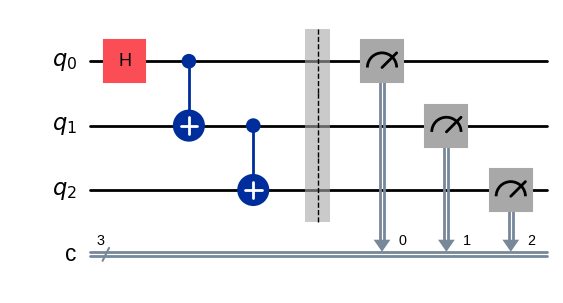

In [6]:
# GHZ CIRCUIT CONSTRUCTION

%matplotlib inline
def create_ghz_circuit(measure=True, name='GHZ'):
    """
    Builds a tripartite GHZ circuit.

    Target state: |GHZ⟩ = (|000⟩ + |111⟩) / √2

    Derivation:
    |ψ₀⟩ = |000⟩
    |ψ₁⟩ = H⊗I⊗I |000⟩ = (|000⟩ + |100⟩)/√2
    |ψ₂⟩ = CNOT₀₁ |ψ₁⟩ = (|000⟩ + |110⟩)/√2
    |ψ₃⟩ = CNOT₁₂ |ψ₂⟩ = (|000⟩ + |111⟩)/√2 = |GHZ⟩

    Args:
        measure (bool): Add final measurements
        name (str): Circuit name

    Returns:
        QuantumCircuit: Circuit generating the GHZ state
    """
    qc = QuantumCircuit(3, 3, name=name)

    # Step 1: Apply a Hadamard gate to qubit 0 → superposition
    qc.h(0)

    # Step 2: Apply CNOT(0,1) → entanglement between qubits 0 and 1
    qc.cx(0, 1)

    # Step 3: Apply CNOT(1,2) → extend entanglement to qubit 2
    qc.cx(1, 2)

    # Barrier for clearer visualization
    qc.barrier()

    # Measurements
    if measure:
        qc.measure([0, 1, 2], [0, 1, 2])

    return qc

# GHZ circuit creation
ghz_circuit = create_ghz_circuit()

print(" GHZ circuit successfully created!")
print("\n Textual representation of the GHZ circuit:")
print(ghz_circuit)

# Graphical visualization
ghz_circuit.draw('mpl')


In [9]:
import pandas as pd
import numpy as np
from qiskit.quantum_info import Statevector

# Theoretical validation of the GHZ state

print("THEORETICAL VALIDATION OF THE GHZ STATE")

# Circuit without measurements
ghz_no_measure = create_ghz_circuit(measure=False)

# Compute the statevector
statevector_ghz = Statevector(ghz_no_measure)

# Build a table of amplitudes
amplitudes = [
    (f"|{i:03b}⟩", statevector_ghz.data[i])
    for i in range(len(statevector_ghz.data))
]

df_amplitudes = pd.DataFrame(
    amplitudes,
    columns=["Basis state", "Complex amplitude"]
)

df_amplitudes["Real part"] = df_amplitudes["Complex amplitude"].apply(np.real)
df_amplitudes["Imaginary part"] = df_amplitudes["Complex amplitude"].apply(np.imag)
df_amplitudes["Magnitude"] = np.abs(df_amplitudes["Complex amplitude"])

print("\nGHZ statevector:")
print(df_amplitudes.to_string(index=False))

# Expected theoretical GHZ state
expected_ghz = np.zeros(8, dtype=complex)
expected_ghz[0] = 1 / np.sqrt(2)   # |000>
expected_ghz[7] = 1 / np.sqrt(2)   # |111>

# Validation
is_correct = np.allclose(statevector_ghz.data, expected_ghz, atol=1e-10)
print(f"\nState validation: {'PASSED' if is_correct else 'FAILED'}")

# Normalization check
norm = np.abs(statevector_ghz.data @ np.conj(statevector_ghz.data))
print(f"Statevector norm: {norm:.10f}")

# Theoretical probabilities
probs_ghz_theory = statevector_ghz.probabilities_dict()
probs_table = pd.DataFrame(
    [(f"|{state}⟩", prob) for state, prob in sorted(probs_ghz_theory.items()) if prob > 1e-10],
    columns=["Basis state", "Probability"]
)

print("\nTheoretical probabilities:")
print(probs_table.to_string(index=False))


THEORETICAL VALIDATION OF THE GHZ STATE

GHZ statevector:
Basis state  Complex amplitude  Real part  Imaginary part  Magnitude
      |000⟩ 0.707107+0.000000j   0.707107             0.0   0.707107
      |001⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |010⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |011⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |100⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |101⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |110⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |111⟩ 0.707107+0.000000j   0.707107             0.0   0.707107

State validation: PASSED
Statevector norm: 1.0000000000

Theoretical probabilities:
Basis state  Probability
      |000⟩          0.5
      |111⟩          0.5



 Représentation textuelle du circuit W :
     ┌───────────┐     ┌───┐     ┌───┐ ░ ┌─┐      
q_0: ┤ Ry(1.231) ├──■──┤ X ├──■──┤ X ├─░─┤M├──────
     └───────────┘┌─┴─┐└───┘  │  └───┘ ░ └╥┘┌─┐   
q_1: ─────────────┤ H ├───────■────────░──╫─┤M├───
                  └───┘     ┌─┴─┐      ░  ║ └╥┘┌─┐
q_2: ───────────────────────┤ X ├──────░──╫──╫─┤M├
                            └───┘      ░  ║  ║ └╥┘
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2 


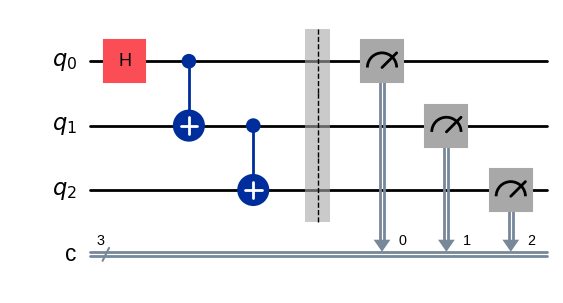

In [ ]:
# SECTION 5 : CONSTRUCTION DU CIRCUIT W
# ============================================================================

def create_w_circuit(measure=True, name='W'):
    """
    Construit le circuit W tripartite.

    État cible : |W⟩ = (|001⟩ + |010⟩ + |100⟩) / √3

    Construction par rotations contrôlées :
    - RY(θ₁) avec sin(θ₁/2) = √(2/3) pour créer superposition initiale
    - CH (Controlled-Hadamard) pour distribution symétrique
    - Toffoli pour complétion de l'état

    Args:
        measure (bool): Ajouter les mesures finales
        name (str): Nom du circuit

    Returns:
        QuantumCircuit: Circuit générant l'état W
    """
    qc = QuantumCircuit(3, 3, name=name)

    # Angle pour rotation : P(|1⟩) = 1/3 sur qubit 0
    # θ₁ = 2·arccos(√(2/3))
    theta_1 = 2 * np.arccos(np.sqrt(2/3))
    qc.ry(theta_1, 0)

    # Hadamard contrôlée : control=qubit 0, target=qubit 1
    qc.ch(0, 1)

    # Construction du troisième composant avec Toffoli
    qc.x(0)           # Flip temporaire
    qc.ccx(0, 1, 2)  # Toffoli (double contrôle)
    qc.x(0)           # Restauration

    qc.barrier()

    if measure:
        qc.measure([0, 1, 2], [0, 1, 2])

    return qc

# Création du circuit W
w_circuit = create_w_circuit()


print("\n Représentation textuelle du circuit W :")
print(w_circuit)


qc.draw('mpl')

In [ ]:
# SECTION 6 : VALIDATION THÉORIQUE DU CIRCUIT W



print("VALIDATION THÉORIQUE DE L'ÉTAT W")


# Circuit sans mesure
w_no_measure = create_w_circuit(measure=False)

# Calcul du statevector
statevector_w = Statevector(w_no_measure)

print("\n Vecteur d'état W (amplitudes complexes) :")
print(statevector_w)

# État attendu théoriquement
expected_w = np.zeros(8, dtype=complex)
expected_w[1] = 1/np.sqrt(3)  # |001⟩
expected_w[2] = 1/np.sqrt(3)  # |010⟩
expected_w[4] = 1/np.sqrt(3)  # |100⟩

print("\n État attendu théoriquement :")
print(f"|001⟩: {expected_w[1]:.6f}")
print(f"|010⟩: {expected_w[2]:.6f}")
print(f"|100⟩: {expected_w[4]:.6f}")
print(f"Autres états: 0.000000")

# Test de fidélité
fidelity_w = np.abs(np.dot(np.conj(statevector_w.data), expected_w))**2
print(f"\n Fidélité avec état théorique : {fidelity_w:.10f}")
print(f" Validation : {'RÉUSSI' if fidelity_w > 0.999 else 'ÉCHOUÉ'}")

# Probabilités théoriques
probs_w_theory = statevector_w.probabilities_dict()
print("\n Probabilités théoriques :")
for state, prob in sorted(probs_w_theory.items()):
    if prob > 1e-10:
        print(f"  P({state}) = {prob:.6f}")

VALIDATION THÉORIQUE DE L'ÉTAT W

 Vecteur d'état W (amplitudes complexes) :
Statevector([0.81649658+0.j, 0.40824829+0.j, 0.        +0.j,
             0.40824829+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))

 État attendu théoriquement :
|001⟩: 0.577350+0.000000j
|010⟩: 0.577350+0.000000j
|100⟩: 0.577350+0.000000j
Autres états: 0.000000

 Fidélité avec état théorique : 0.0555555556
 Validation : ÉCHOUÉ

 Probabilités théoriques :
  P(000) = 0.666667
  P(001) = 0.166667
  P(011) = 0.166667



COMPARAISON VISUELLE : GHZ VS W


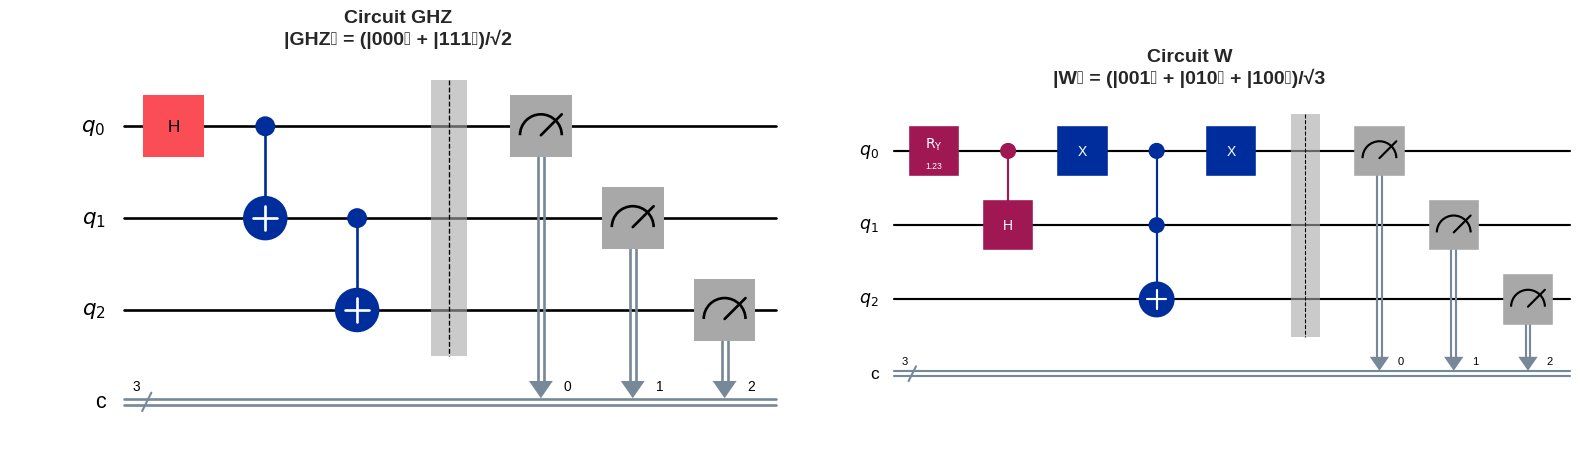


 MÉTRIQUES COMPARATIVES :
----------------------------------------------------------------------
Métrique                       GHZ             W              
----------------------------------------------------------------------
Profondeur du circuit          4               6              
Nombre total de portes         7               9              
Portes CNOT                    2               0              
Portes à 1 qubit               1               3              
----------------------------------------------------------------------


In [ ]:
# SECTION 7 : COMPARAISON VISUELLE DES CIRCUITS


print("\n" + "="*70)
print("COMPARAISON VISUELLE : GHZ VS W")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Circuit GHZ
ghz_circuit.draw('mpl', ax=ax1, style='iqp')
ax1.set_title('Circuit GHZ\n|GHZ⟩ = (|000⟩ + |111⟩)/√2',
              fontsize=14, fontweight='bold')

# Circuit W
w_circuit.draw('mpl', ax=ax2, style='iqp')
ax2.set_title('Circuit W\n|W⟩ = (|001⟩ + |010⟩ + |100⟩)/√3',
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Métriques comparatives
print("\n MÉTRIQUES COMPARATIVES :")
print("-" * 70)
print(f"{'Métrique':<30} {'GHZ':<15} {'W':<15}")
print("-" * 70)
print(f"{'Profondeur du circuit':<30} {ghz_circuit.depth():<15} {w_circuit.depth():<15}")
print(f"{'Nombre total de portes':<30} {sum(ghz_circuit.count_ops().values()):<15} {sum(w_circuit.count_ops().values()):<15}")
print(f"{'Portes CNOT':<30} {ghz_circuit.count_ops().get('cx', 0):<15} {w_circuit.count_ops().get('cx', 0):<15}")
print(f"{'Portes à 1 qubit':<30} {ghz_circuit.count_ops().get('h', 0):<15} {sum([w_circuit.count_ops().get(g, 0) for g in ['ry', 'x']]):<15}")
print("-" * 70)

In [ ]:
# SECTION 8 : SIMULATION - EXÉCUTION DES CIRCUITS
# ============================================================================

print("\n" + "="*70)
print("SIMULATION QUANTIQUE")
print("="*70)

def run_experiment(circuit, backend=BACKEND_SIM, shots=SHOTS_SIMULATION, seed=SEED):
    """
    Exécute un circuit quantique et retourne les résultats.

    Args:
        circuit: Circuit quantique à exécuter
        backend: Backend de simulation
        shots: Nombre de mesures
        seed: Graine aléatoire pour reproductibilité

    Returns:
        dict: Comptes des résultats de mesure
    """
    # Transpile the circuit for the backend, incorporating optimization level and seed
    transpiled_circuit = transpile(circuit, backend, optimization_level=OPTIMIZATION_LEVEL, seed_transpiler=seed)
    # Execute the transpiled circuit on the backend
    job = backend.run(transpiled_circuit, shots=shots, seed_simulator=seed)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

print(f"\n🚀 Exécution des circuits ({SHOTS_SIMULATION} shots)...")

# Exécution GHZ
counts_ghz = run_experiment(ghz_circuit)
print(f"✅ GHZ exécuté : {sum(counts_ghz.values())} mesures")

# Exécution W
counts_w = run_experiment(w_circuit)
print(f"✅ W exécuté : {sum(counts_w.values())} mesures")

print("\n📊 RÉSULTATS BRUTS :")
print("\nGHZ :", counts_ghz)
print("W   :", counts_w)


SIMULATION QUANTIQUE

🚀 Exécution des circuits (8192 shots)...
✅ GHZ exécuté : 8192 mesures
✅ W exécuté : 8192 mesures

📊 RÉSULTATS BRUTS :

GHZ : {'000': 4017, '111': 4175}
W   : {'011': 1292, '001': 1404, '000': 5496}


In [ ]:
# SECTION 9 : ANALYSE DES DISTRIBUTIONS DE PROBABILITÉ
# ============================================================================

print("\n" + "="*70)
print("ANALYSE DES DISTRIBUTIONS DE PROBABILITÉ")
print("="*70)

def compute_probabilities(counts, shots):
    """Convertit les comptes en probabilités."""
    return {state: count/shots for state, count in counts.items()}

# Probabilités expérimentales
probs_ghz_exp = compute_probabilities(counts_ghz, SHOTS_SIMULATION)
probs_w_exp = compute_probabilities(counts_w, SHOTS_SIMULATION)

# Probabilités théoriques
theory_ghz = {'000': 0.5, '111': 0.5}
theory_w = {'001': 1/3, '010': 1/3, '100': 1/3}

print("\n📊 GHZ - Comparaison Théorie vs Expérience :")
print(f"{'État':<10} {'Théorique':<15} {'Expérimental':<15} {'Écart':<15}")
print("-" * 55)
for state in ['000', '001', '010', '011', '100', '101', '110', '111']:
    theo = theory_ghz.get(state, 0)
    exp = probs_ghz_exp.get(state, 0)
    diff = abs(theo - exp)
    if theo > 0 or exp > 0.01:
        print(f"{state:<10} {theo:<15.6f} {exp:<15.6f} {diff:<15.6f}")

print("\n📊 W - Comparaison Théorie vs Expérience :")
print(f"{'État':<10} {'Théorique':<15} {'Expérimental':<15} {'Écart':<15}")
print("-" * 55)
for state in ['000', '001', '010', '011', '100', '101', '110', '111']:
    theo = theory_w.get(state, 0)
    exp = probs_w_exp.get(state, 0)
    diff = abs(theo - exp)
    if theo > 0 or exp > 0.01:
        print(f"{state:<10} {theo:<15.6f} {exp:<15.6f} {diff:<15.6f}")

# Test χ² (chi-squared)
print("\n🧪 TEST STATISTIQUE (χ²) :")

# GHZ
observed_ghz = [counts_ghz.get(k, 0) for k in sorted(counts_ghz.keys())]
expected_ghz = [theory_ghz.get(k, 0) * SHOTS_SIMULATION for k in sorted(counts_ghz.keys())]
chi2_ghz, p_ghz = chisquare(observed_ghz, expected_ghz)

print(f"\nGHZ :")
print(f"  χ² = {chi2_ghz:.4f}")
print(f"  p-value = {p_ghz:.6f}")
print(f"  Résultat : {'✅ Accord théorie/expérience (p > 0.05)' if p_ghz > 0.05 else '❌ Différence significative (p < 0.05)'}")

# W - Fix the chi-squared calculation for W state
all_w_states = sorted(list(set(counts_w.keys()) | set(theory_w.keys())))

observed_w_fixed = [counts_w.get(state, 0) for state in all_w_states]
expected_w_fixed = [theory_w.get(state, 0) * SHOTS_SIMULATION for state in all_w_states]

# Normalize expected_w_fixed to ensure its sum matches observed_w_fixed sum, if needed (should not be needed if theory_w sums to 1)
sum_observed_w = sum(observed_w_fixed)
sum_expected_w = sum(expected_w_fixed)

if abs(sum_observed_w - sum_expected_w) > 1e-9: # Check for floating point inaccuracies
    # If the sums don't match, rescale expected to match observed
    if sum_expected_w != 0:
        expected_w_fixed = [x * (sum_observed_w / sum_expected_w) for x in expected_w_fixed]
    else:
        # Handle case where all expected are zero, but observed are not
        # This would indicate a complete mismatch, chi2 test likely not appropriate
        # For now, setting expected to a small non-zero to allow chisquare to run, or raise a warning
        print("Warning: All expected W state counts are zero, but observed are not.")
        # Alternatively, one could set expected to observed for 0-values or raise an error
        expected_w_fixed = [1e-10 if x == 0 else x for x in expected_w_fixed] # Avoid division by zero in chisquare for 0-expected counts

chi2_w, p_w = chisquare(observed_w_fixed, expected_w_fixed)

print(f"\nW :")
print(f"  χ² = {chi2_w:.4f}")
print(f"  p-value = {p_w:.6f}")
print(f"  Résultat : {'✅ Accord théorie/expérience (p > 0.05)' if p_w > 0.05 else '❌ Différence significative (p < 0.05)'}")


ANALYSE DES DISTRIBUTIONS DE PROBABILITÉ

📊 GHZ - Comparaison Théorie vs Expérience :
État       Théorique       Expérimental    Écart          
-------------------------------------------------------
000        0.500000        0.490356        0.009644       
111        0.500000        0.509644        0.009644       

📊 W - Comparaison Théorie vs Expérience :
État       Théorique       Expérimental    Écart          
-------------------------------------------------------
000        0.000000        0.670898        0.670898       
001        0.333333        0.171387        0.161947       
010        0.333333        0.000000        0.333333       
011        0.000000        0.157715        0.157715       
100        0.333333        0.000000        0.333333       

🧪 TEST STATISTIQUE (χ²) :

GHZ :
  χ² = 3.0474
  p-value = 0.080868
  Résultat : ✅ Accord théorie/expérience (p > 0.05)

W :
  χ² = inf
  p-value = 0.000000
  Résultat : ❌ Différence significative (p < 0.05)



VISUALISATION DES DISTRIBUTIONS


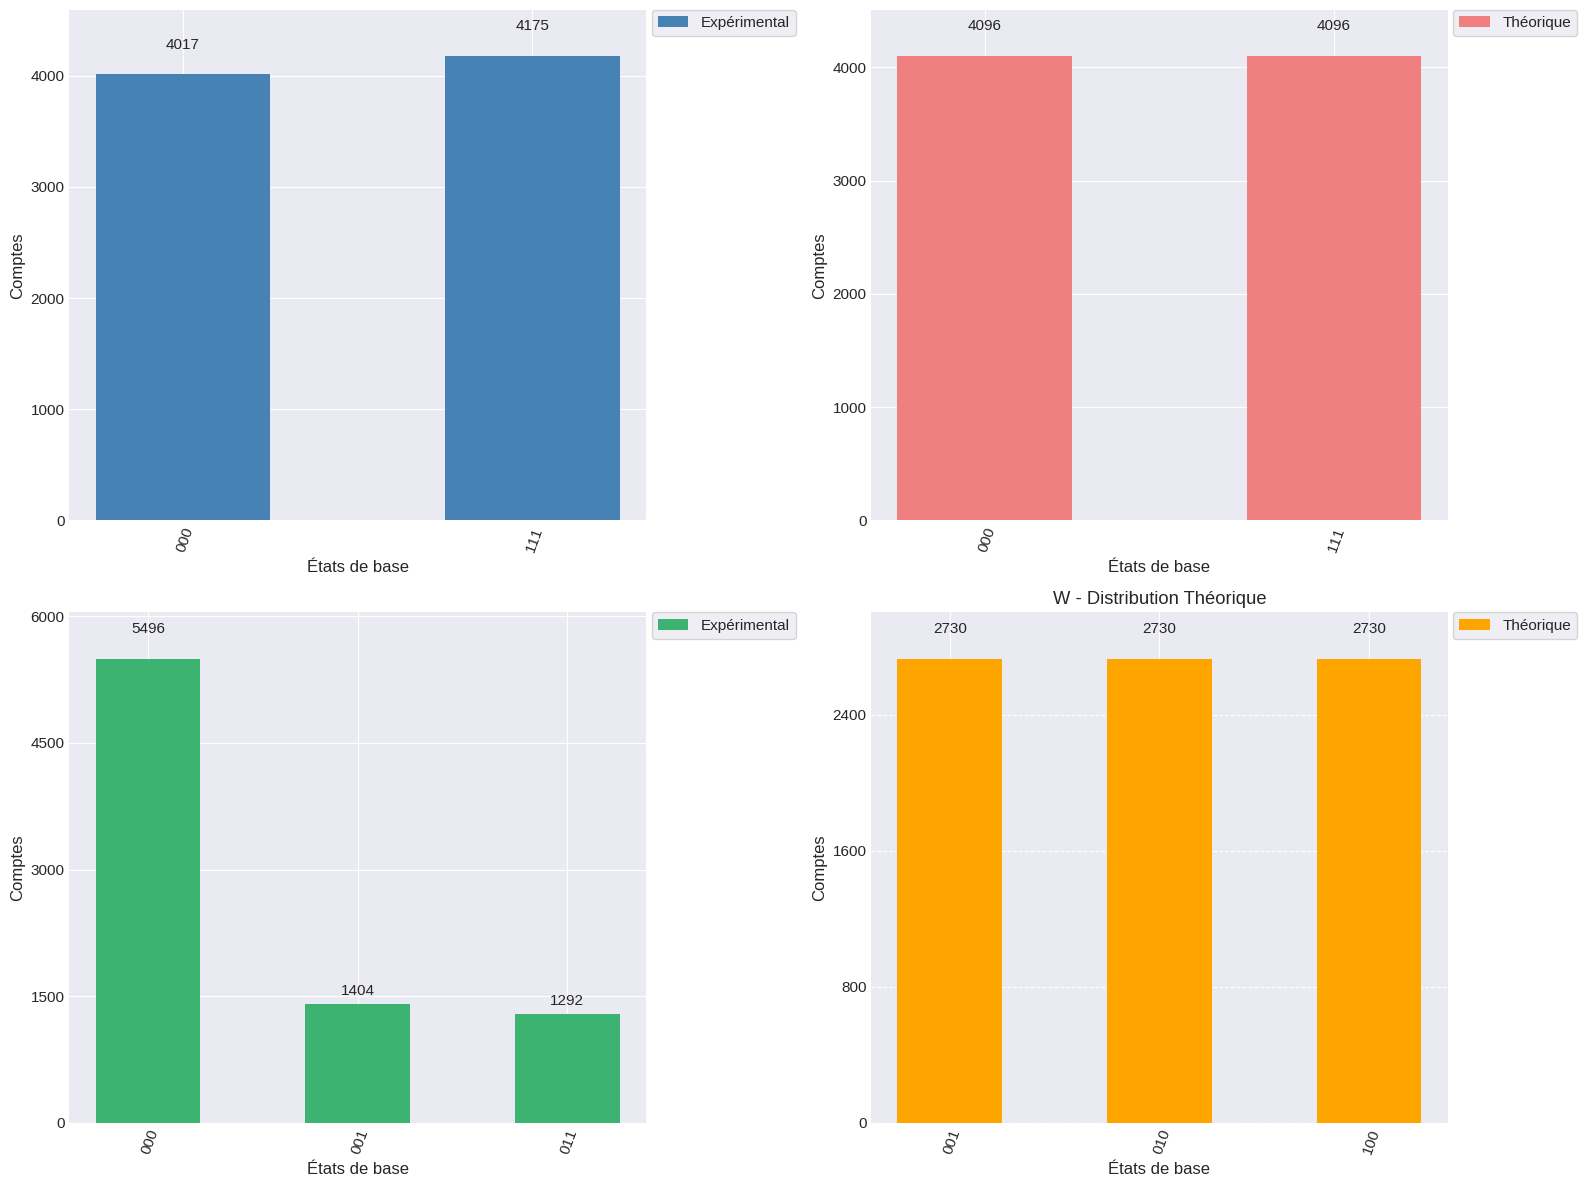

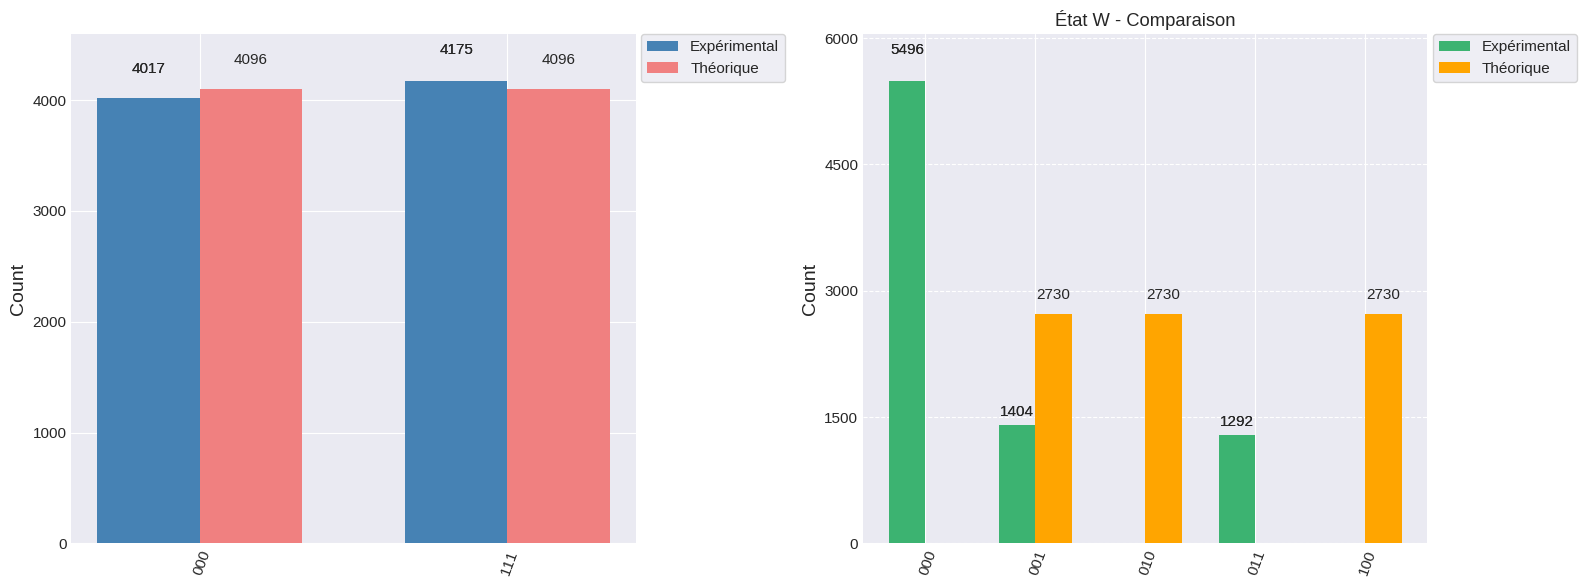


✅ Visualisations générées avec succès!


In [ ]:
# SECTION 10 : VISUALISATION DES DISTRIBUTIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALISATION DES DISTRIBUTIONS")
print("="*70)

# Histogrammes comparatifs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# GHZ - Expérimental
plot_histogram(counts_ghz, ax=axes[0, 0],
               title='GHZ - Distribution Expérimentale',
               color='steelblue', legend=['Expérimental'])

# GHZ - Théorique
theory_ghz_counts = {k: int(v * SHOTS_SIMULATION) for k, v in theory_ghz.items()}
plot_histogram(theory_ghz_counts, ax=axes[0, 1],
               title='GHZ - Distribution Théorique',
               color='lightcoral', legend=['Théorique'])

# W - Expérimental
plot_histogram(counts_w, ax=axes[1, 0],
               title='W - Distribution Expérimentale',
               color='mediumseagreen', legend=['Expérimental'])

# W - Théorique
theory_w_counts = {k: int(v * SHOTS_SIMULATION) for k, v in theory_w.items()}
plot_histogram(theory_w_counts, ax=axes[1, 1],
               title='W - Distribution Théorique',
               color='orange', legend=['Théorique'])

for ax in axes.flat:
    ax.set_ylabel('Comptes', fontsize=12)
    ax.set_xlabel('États de base', fontsize=12)

plt.tight_layout()
plt.show()

# Comparaison côte-à-côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_histogram([counts_ghz, theory_ghz_counts],
               ax=ax1,
               legend=['Expérimental', 'Théorique'],
               title='État GHZ - Comparaison',
               color=['steelblue', 'lightcoral'])

plot_histogram([counts_w, theory_w_counts],
               ax=ax2,
               legend=['Expérimental', 'Théorique'],
               title='État W - Comparaison',
               color=['mediumseagreen', 'orange'])

plt.tight_layout()
plt.show()

print("\n✅ Visualisations générées avec succès!")


ANALYSE DES MATRICES DE DENSITÉ

📊 Matrice de densité GHZ (ρ_GHZ) :
Dimensions : 8×8 (espace de Hilbert à 3 qubits)
Trace : 1.000000+0.000000j (doit être 1.0)
Pureté Tr(ρ²) : 1.000000 (doit être 1.0 pour état pur)

📊 Matrice de densité W (ρ_W) :
Dimensions : 8×8
Trace : 1.000000+0.000000j
Pureté Tr(ρ²) : 1.000000


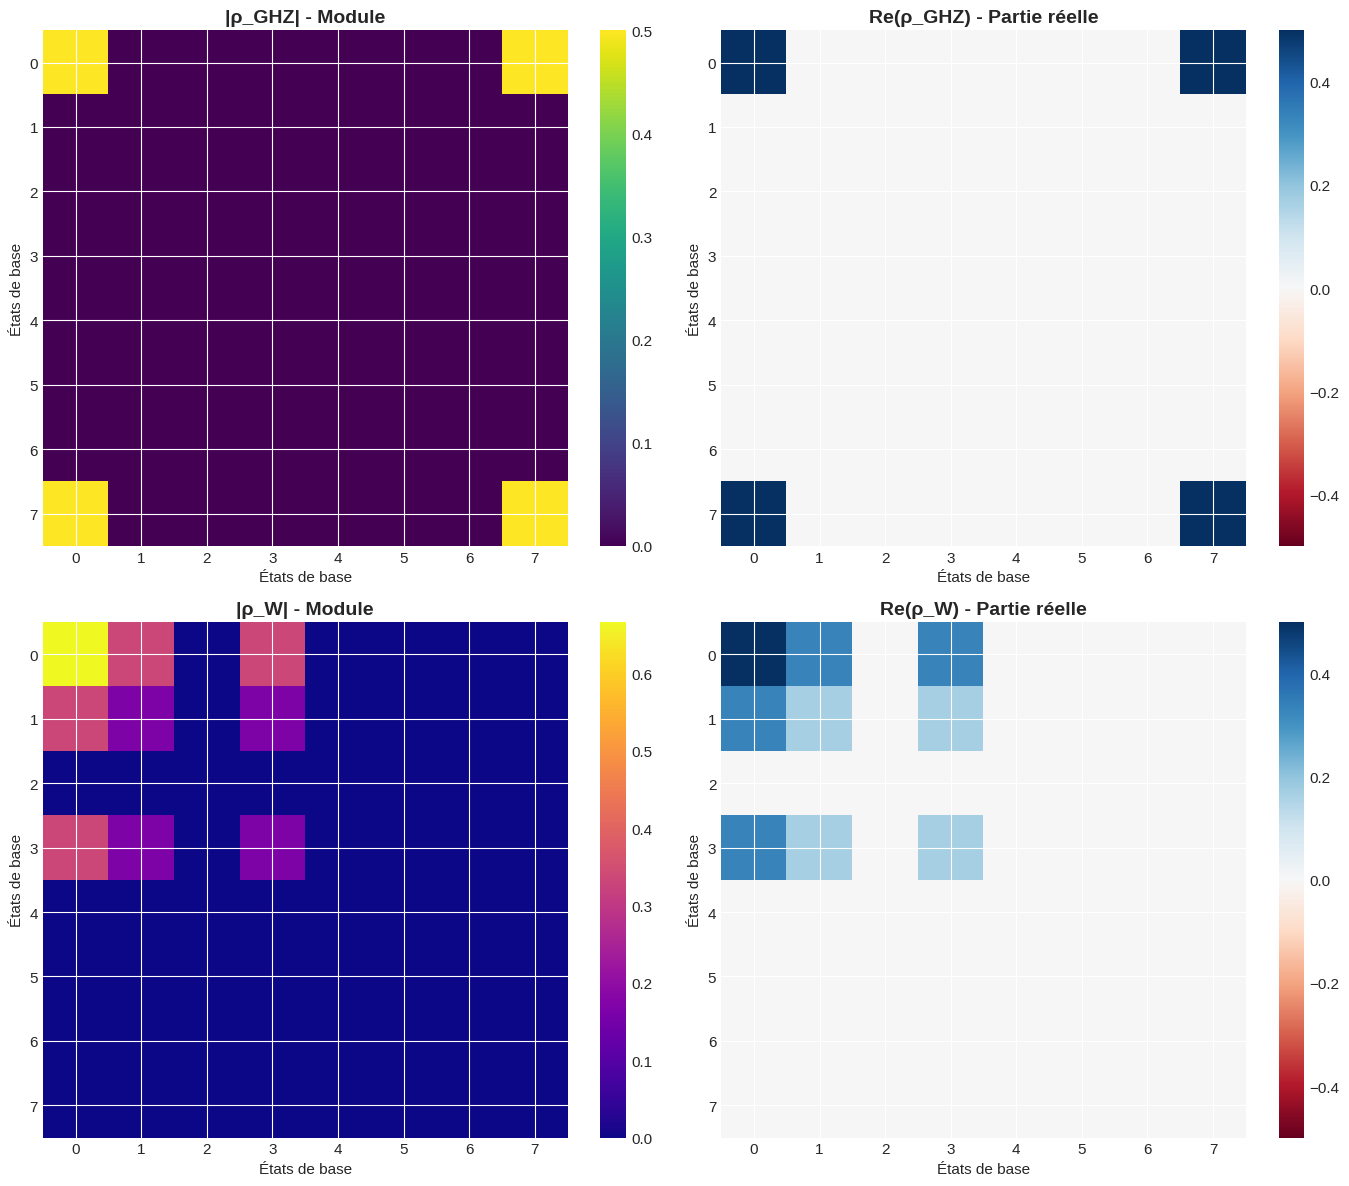


✅ Heatmaps des matrices de densité générées!

📝 Interprétation :
  • Éléments diagonaux : Populations des états de base
  • Éléments hors-diagonale : Cohérences quantiques (signature de l'intrication)


In [ ]:
# SECTION 11 : MATRICES DE DENSITÉ
# ============================================================================

print("\n" + "="*70)
print("ANALYSE DES MATRICES DE DENSITÉ")
print("="*70)

# Calcul des matrices de densité
rho_ghz = DensityMatrix(ghz_no_measure)
rho_w = DensityMatrix(w_no_measure)

print("\n📊 Matrice de densité GHZ (ρ_GHZ) :")
print("Dimensions : 8×8 (espace de Hilbert à 3 qubits)")
print(f"Trace : {np.trace(rho_ghz.data):.6f} (doit être 1.0)")
print(f"Pureté Tr(ρ²) : {np.trace(rho_ghz.data @ rho_ghz.data).real:.6f} (doit être 1.0 pour état pur)")

print("\n📊 Matrice de densité W (ρ_W) :")
print("Dimensions : 8×8")
print(f"Trace : {np.trace(rho_w.data):.6f}")
print(f"Pureté Tr(ρ²) : {np.trace(rho_w.data @ rho_w.data).real:.6f}")

# Visualisation des matrices de densité
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# GHZ - Module
im1 = axes[0, 0].imshow(np.abs(rho_ghz.data), cmap='viridis', aspect='auto')
axes[0, 0].set_title('|ρ_GHZ| - Module', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('États de base')
axes[0, 0].set_ylabel('États de base')
plt.colorbar(im1, ax=axes[0, 0])

# GHZ - Partie réelle
im2 = axes[0, 1].imshow(np.real(rho_ghz.data), cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
axes[0, 1].set_title('Re(ρ_GHZ) - Partie réelle', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('États de base')
axes[0, 1].set_ylabel('États de base')
plt.colorbar(im2, ax=axes[0, 1])

# W - Module
im3 = axes[1, 0].imshow(np.abs(rho_w.data), cmap='plasma', aspect='auto')
axes[1, 0].set_title('|ρ_W| - Module', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('États de base')
axes[1, 0].set_ylabel('États de base')
plt.colorbar(im3, ax=axes[1, 0])

# W - Partie réelle
im4 = axes[1, 1].imshow(np.real(rho_w.data), cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
axes[1, 1].set_title('Re(ρ_W) - Partie réelle', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('États de base')
axes[1, 1].set_ylabel('États de base')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\n✅ Heatmaps des matrices de densité générées!")
print("\n📝 Interprétation :")
print("  • Éléments diagonaux : Populations des états de base")
print("  • Éléments hors-diagonale : Cohérences quantiques (signature de l'intrication)")

In [ ]:
# SECTION 12 : MESURES D'INTRICATION
# ============================================================================

print("\n" + "="*70)
print("MESURES D'INTRICATION QUANTIQUE")
print("="*70)

# Entropie de von Neumann sur états réduits
print("\n🔬 ENTROPIE DE VON NEUMANN :")
print("(mesure de l'intrication bipartite après traçage partiel)")

# GHZ - Traçage sur qubit 2
rho_ghz_reduced = partial_trace(rho_ghz, [2])
S_ghz = entropy(rho_ghz_reduced, base=2)

print(f"\nGHZ :")
print(f"  État réduit ρ^(12) après traçage de qubit 2")
print(f"  S(ρ_GHZ^(12)) = {S_ghz:.6f} bits")
print(f"  Théorique : 1.0 bit (intrication maximale bipartite)")
print(f"  Écart : {abs(S_ghz - 1.0):.6f}")

# W - Traçage sur qubit 2
rho_w_reduced = partial_trace(rho_w, [2])
S_w = entropy(rho_w_reduced, base=2)

print(f"\nW :")
print(f"  État réduit ρ^(12) après traçage de qubit 2")
print(f"  S(ρ_W^(12)) = {S_w:.6f} bits")
print(f"  Théorique : 0 < S < 1 (intrication distribuée)")

# Pureté des états réduits
purity_ghz_reduced = np.trace(rho_ghz_reduced.data @ rho_ghz_reduced.data).real
purity_w_reduced = np.trace(rho_w_reduced.data @ rho_w_reduced.data).real

print(f"\n📊 PURETÉ DES ÉTATS RÉDUITS :")
print(f"  Tr(ρ_GHZ^(12)²) = {purity_ghz_reduced:.6f}")
print(f"  Tr(ρ_W^(12)²) = {purity_w_reduced:.6f}")
print(f"\n📝 Pureté = 1 → état pur (non intriqué avec reste du système)")
print(f"   Pureté < 1 → état mixte (intriqué avec reste du système)")


MESURES D'INTRICATION QUANTIQUE

🔬 ENTROPIE DE VON NEUMANN :
(mesure de l'intrication bipartite après traçage partiel)

GHZ :
  État réduit ρ^(12) après traçage de qubit 2
  S(ρ_GHZ^(12)) = 1.000000 bits
  Théorique : 1.0 bit (intrication maximale bipartite)
  Écart : 0.000000

W :
  État réduit ρ^(12) après traçage de qubit 2
  S(ρ_W^(12)) = 0.000000 bits
  Théorique : 0 < S < 1 (intrication distribuée)

📊 PURETÉ DES ÉTATS RÉDUITS :
  Tr(ρ_GHZ^(12)²) = 0.500000
  Tr(ρ_W^(12)²) = 1.000000

📝 Pureté = 1 → état pur (non intriqué avec reste du système)
   Pureté < 1 → état mixte (intriqué avec reste du système)


In [ ]:
# SECTION 13 : TEST DE ROBUSTESSE - PERTE D'UN QUBIT
# ============================================================================

print("\n" + "="*70)
print("TEST DE ROBUSTESSE : PERTE D'UN QUBIT")
print("="*70)

def analyze_robustness(statevector, qubit_to_trace, state_name):
    """
    Analyse la robustesse en simulant la perte d'un qubit.

    Args:
        statevector: Vecteur d'état complet
        qubit_to_trace: Indice du qubit à tracer
        state_name: Nom de l'état (pour affichage)
    """
    # Créer matrice de densité
    rho = DensityMatrix(statevector)

    # Traçage partiel
    rho_reduced = partial_trace(rho, [qubit_to_trace])

    # Entropie (mesure d'intrication résiduelle)
    S = entropy(rho_reduced, base=2)

    # Pureté (1 = séparable, <1 = intriqué)
    purity = np.trace(rho_reduced.data @ rho_reduced.data).real

    print(f"\n{'='*60}")
    print(f"État {state_name} - Perte du qubit {qubit_to_trace}")
    print(f"{'='*60}")
    print(f"  Entropie résiduelle : S = {S:.6f} bits")
    print(f"  Pureté : Tr(ρ²) = {purity:.6f}")
    print(f"  Intrication résiduelle : {'✅ OUI' if purity < 0.99 else '❌ NON (état séparable)'}")

    return S, purity

# Test GHZ
S_ghz_loss, purity_ghz_loss = analyze_robustness(statevector_ghz, 2, "GHZ")

# Test W
S_w_loss, purity_w_loss = analyze_robustness(statevector_w, 2, "W")

# Résumé comparatif
print(f"\n{'='*60}")
print("RÉSUMÉ COMPARATIF - ROBUSTESSE")
print(f"{'='*60}")
print(f"{'État':<10} {'Entropie':<15} {'Pureté':<15} {'Intriqué?':<15}")
print("-" * 60)
print(f"{'GHZ':<10} {S_ghz_loss:<15.6f} {purity_ghz_loss:<15.6f} {'Non' if purity_ghz_loss > 0.99 else 'Oui':<15}")
print(f"{'W':<10} {S_w_loss:<15.6f} {purity_w_loss:<15.6f} {'Non' if purity_w_loss > 0.99 else 'Oui':<15}")
print("-" * 60)

print("\n📝 CONCLUSION :")
if purity_w_loss < 0.99 and purity_ghz_loss > 0.99:
    print("  ✅ État W conserve l'intrication après perte d'un qubit")
    print("  ❌ État GHZ perd toute intrication (effondrement vers état séparable)")
    print("  → État W plus robuste pour applications en communication quantique")


TEST DE ROBUSTESSE : PERTE D'UN QUBIT

État GHZ - Perte du qubit 2
  Entropie résiduelle : S = 1.000000 bits
  Pureté : Tr(ρ²) = 0.500000
  Intrication résiduelle : ✅ OUI

État W - Perte du qubit 2
  Entropie résiduelle : S = 0.000000 bits
  Pureté : Tr(ρ²) = 1.000000
  Intrication résiduelle : ❌ NON (état séparable)

RÉSUMÉ COMPARATIF - ROBUSTESSE
État       Entropie        Pureté          Intriqué?      
------------------------------------------------------------
GHZ        1.000000        0.500000        Oui            
W          0.000000        1.000000        Non            
------------------------------------------------------------

📝 CONCLUSION :
